In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
from timeit import default_timer as timer
import pyomo.environ as pyo

from env.model import *
from env.utils import *
from functions import *


def evaluate_total_cost(mapping, program, network):
    s = 0
    for o in program.P.nodes:
        des = get_mapped_node(mapping, o)
        s += program.T[o, des]

    for e in program.P.edges:
        d1 = get_mapped_node(mapping, e[0])
        d2 = get_mapped_node(mapping, e[1])
        b = program.B[e]
        s += network.communication_delay(b, d1, d2)
    return s


def exhaustive_total_cost(mapping, program, network):
    to_be_mapped = []
    constraints = program.placement_constraints
    for i in nx.topological_sort(program.P):
        if np.sum(mapping[i]) < 1:
            to_be_mapped.append(i)
    l = len(to_be_mapped)

    def helper(to_be, idx, constraints):
        if idx == len(to_be) - 1:
            for node in constraints[to_be[idx]]:
                yield [node]
        else:
            for node in constraints[to_be[idx]]:
                partial_mapping = helper(to_be, idx + 1, constraints)
                for p_m in partial_mapping:
                    p_m.append(node)
                    yield p_m

    min_L = np.inf
    min_mapping = None
    mapp = np.copy(mapping)
    solution = []

    for mapped in helper(to_be_mapped, 0, constraints):
        for i in range(l):
            mapp[to_be_mapped[i]] = 0
            mapp[to_be_mapped[i], mapped[-1 - i]] = 1
        latency_i = evaluate_total_cost(mapp, program, network)
        solution.append(latency_i)
        if latency_i < min_L:
            min_L = latency_i
            min_mapping = np.copy(mapp)
    return min_mapping, min_L, solution


def qlp_total_cost(mapping, program, network):
    mapp = np.copy(mapping)
    T = program.T
    B = program.B
    R = network.R
    M = T.shape[0]
    N = T.shape[1]
    model = pyo.ConcreteModel(name='Linear constraint')
    model.x = pyo.Var(range(M), range(N), domain=pyo.Binary, initialize=1)

    def _obj(m):
        summ = 0
        for i in range(M):
            for j in range(N):
                if T[i, j] < np.inf:
                    summ += T[i, j] * m.x[i, j]
        for i in range(M):
            for j in range(M):
                for k in range(N):
                    for l in range(N):
                        summ += m.x[i, k] * m.x[j, l] * (B[i, j] * R[l, k])
        return summ

    model.obj = pyo.Objective(rule=_obj, sense=pyo.minimize)

    model.c = pyo.ConstraintList()
    model.c.add(model.x[0, program.pinned[0]] == 1)
    model.c.add(model.x[M - 1, program.pinned[1]] == 1)
    for i in range(M):
        model.c.add(sum(model.x[i, j] for j in range(N)) == 1)
        model.c.add(sum(model.x[i, j] for j in list(program.placement_constraints[i])) == 1)

#     model.pprint()

    baron = pyo.SolverFactory('baron', executable='~/baron-osx64/baron')
    result_obj = baron.solve(model, tee=False)
#     for i in model.x:
#         print (str(model.x[i]), model.x[i].value)
    solution = [j for i in range(M) for j in range(N) if pyo.value(model.x[i, j]) > 0]
    for i in range(M):
        mapp[i] = 0
        mapp[i, solution[i]] = 1
    return mapp


def iterative_total_cost(mapping, program, network):
    map = np.copy(mapping)
    constraints = program.placement_constraints
    to_be_mapped = [i for i in range(program.n_operators) if np.sum(mapping[i]) < 1]

    for o in to_be_mapped:
        map[o, np.random.choice(list(constraints[o]))] = 1
        
    def node_cost(o, d):
        c = program.T[o, d]
        for e in program.P.in_edges(o):
            s = e[0]
            c += network.communication_delay(program.B[e], get_mapped_node(map, s), d)
        for e in program.P.out_edges(o):
            s = e[1]
            c += network.communication_delay(program.B[e], d, get_mapped_node(map, s))
        return c
    l_cost = evaluate_total_cost(map, program, network)
    count = 300
    while True:
        np.random.shuffle(to_be_mapped)
        for i in to_be_mapped:
            d = get_mapped_node(map, i)
            c = node_cost(i, d)
            for n in constraints[i]:
                new_c = node_cost(i, n)
                if new_c < c:
                    c = new_c
                    d = n
            map[i] = 0
            map[i, d] = 1
        cost = evaluate_total_cost(map, program, network)
        if cost < l_cost:
            l_cost = cost
        elif count:
            count -= 1
        else:
            break
    return map, l_cost

Case  0
[0, 19]
Iterative


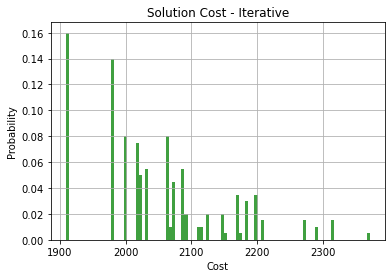

Cost: 2046.734	+-98.968	Minimum: 1909.225	 0.16000000000000006
Running time: 0.530	+-0.057

QLP
[0, 14, 5, 14, 5, 5, 5, 19]
1909.22476184387
2.1003797190001023

Exhaustive
[0, 14, 5, 14, 5, 5, 5, 19]
1909.22476184387
85.10364193800024


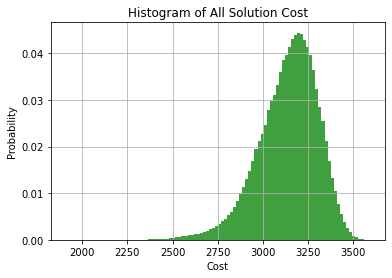

Case  1
[29, 25]
Iterative


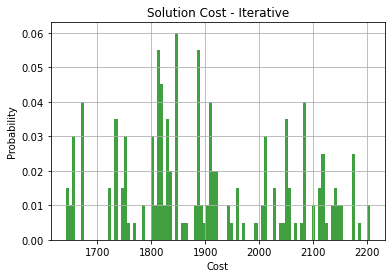

Cost: 1900.364	+-149.059	Minimum: 1641.312	 0.015
Running time: 0.594	+-0.033

QLP
[29, 26, 26, 2, 26, 26, 2, 25]
1641.3121482805072
1.5541604909999478

Exhaustive
[29, 26, 26, 2, 26, 26, 2, 25]
1641.3121482805072
396.0428028000001


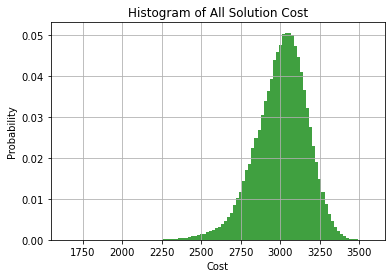

Case  2
[18, 25]
Iterative


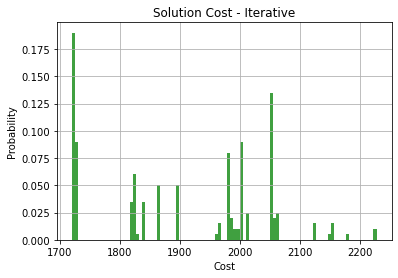

Cost: 1902.478	+-139.841	Minimum: 1720.599	 0.19000000000000009
Running time: 0.557	+-0.032

QLP
[18, 6, 6, 6, 10, 10, 10, 25]
1720.5985956495674
1.6972665579996828

Exhaustive
[18, 6, 6, 6, 10, 10, 10, 25]
1720.5985956495674
221.32813210400036


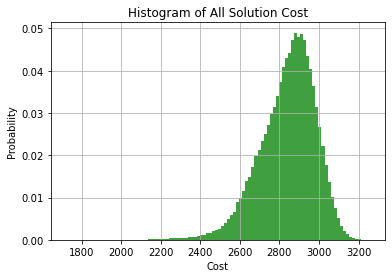

Case  3
[1, 1]
Iterative


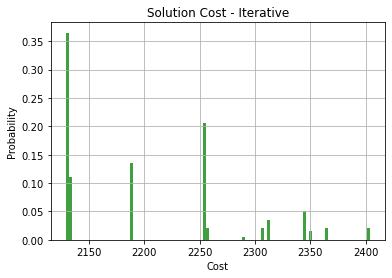

Cost: 2200.496	+-80.559	Minimum: 2128.960	 0.3650000000000002
Running time: 0.420	+-0.021

QLP
[1, 15, 17, 4, 15, 17, 17, 1]
2128.9598937218093
1.7118373180001072

Exhaustive
[1, 15, 17, 4, 15, 17, 17, 1]
2128.9598937218093
33.32836531900011


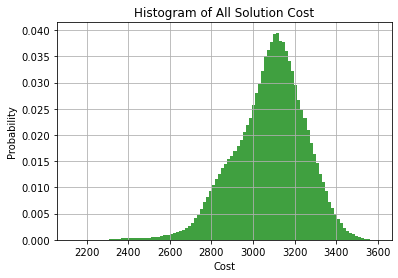

Case  4
[24, 22]
Iterative


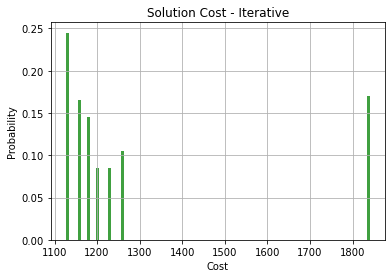

Cost: 1290.688	+-252.525	Minimum: 1126.487	 0.24500000000000013
Running time: 0.551	+-0.028

QLP
[24, 11, 11, 11, 11, 22, 11, 22]
1126.4874647394527
1.5440475619998324

Exhaustive
[24, 11, 11, 11, 11, 22, 11, 22]
1126.4874647394527
171.175568699


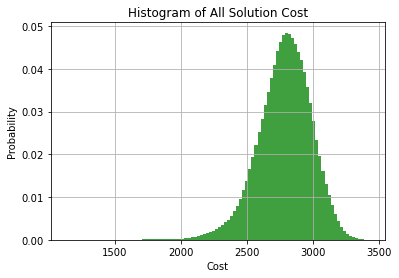

In [4]:
N = 30
M = 8
l = 100
b = 1000

for i in range(5):    
    print('Case ', str(i))
    network = StarNetwork(*generate_network(N, i))
    network.D = np.zeros_like(network.D)
    DAG, constraints = generate_program(M, N, i, b, l)
    program = Program(DAG, constraints, network)
    
    mapping = np.zeros((M, N))
    mapping[0, program.pinned[0]] = 1
    mapping[-1, program.pinned[-1]] = 1
    print(program.pinned)
    print('===========================================')
    print('Iterative')
    cost = []
    time = []
    for i in range(200):
        start = timer()
        mapp, lat = iterative_total_cost(mapping, program, network)
        end = timer()
        cost.append(lat)
        time.append(end-start)
    weights = np.ones_like(cost) / len(cost)
    n, bins, p = plt.hist(cost, 100, weights=weights, facecolor='g', alpha=0.75)
    plt.xlabel('Cost')
    plt.ylabel('Probability')
    plt.title('Solution Cost - Iterative')
    plt.grid(True)
    plt.show()
    
    cost = np.array(cost)
    time = np.array(time)
    print(f"Cost: {np.average(cost):.3f}\t+-{np.std(cost):.3f}\tMinimum: {np.amin(cost):.3f}\t {n[0]}")
    print(f"Running time: {np.average(time):.3f}\t+-{np.std(time):.3f}")
    print('')
    print('===========================================')
    print("QLP")
    start = timer()
    mapp = qlp_total_cost(mapping, program, network)
    end = timer()
    qlp_time = end-start
    print([get_mapped_node(mapp, i) for i in range(M)])
    print(evaluate_total_cost(mapp, program, network))
    print(qlp_time)
    
    print('')
    print('===========================================')
    print("Exhaustive")
    start = timer()
    mapp, Lat, solution = exhaustive_total_cost(mapping, program, network)
    end = timer()
    exhaustive_time = end-start
    print([get_mapped_node(mapp, i) for i in range(M)])
    print(Lat)
    print(exhaustive_time)
    
    weights = np.ones_like(solution) / len(solution)
    plt.hist(solution, 100, weights=weights, facecolor='g', alpha=0.75)
    plt.xlabel('Cost')
    plt.ylabel('Probability')
    plt.title(f'Histogram of All Solution Cost')
    plt.grid(True)
    plt.show()
    
    
    




Case  1
[29, 25]
Iterative


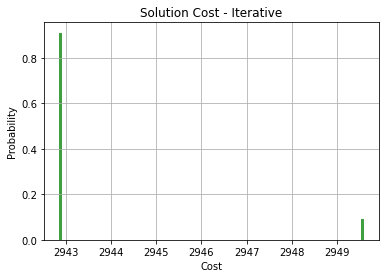

Cost: 2943.465	+-1.926	Minimum: 2942.859	 0.9100000000000007
Running time: 0.566	+-0.019

Case  2
[18, 25]
Iterative


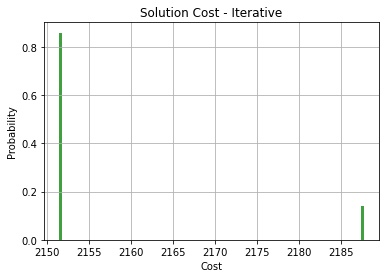

Cost: 2156.516	+-12.596	Minimum: 2151.434	 0.8600000000000007
Running time: 0.536	+-0.029

Case  3
[1, 1]
Iterative


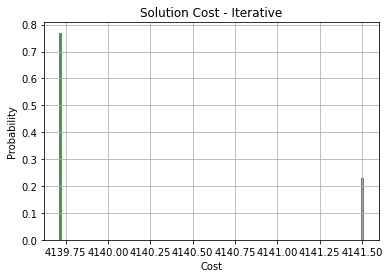

Cost: 4140.127	+-0.756	Minimum: 4139.714	 0.7700000000000006
Running time: 0.427	+-0.040

Case  4
[24, 22]
Iterative


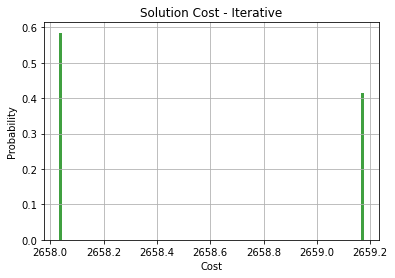

Cost: 2658.508	+-0.562	Minimum: 2658.035	 0.5850000000000004
Running time: 0.543	+-0.032



In [8]:
N = 30
M = 8
l = 1000
b = 100

for i in range(1,5):    
    print('Case ', str(i))
    network = StarNetwork(*generate_network(N, i))
    network.D = np.zeros_like(network.D)
    DAG, constraints = generate_program(M, N, i, b, l)
    program = Program(DAG, constraints, network)
    
    mapping = np.zeros((M, N))
    mapping[0, program.pinned[0]] = 1
    mapping[-1, program.pinned[-1]] = 1
    print(program.pinned)
    print('===========================================')
    print('Iterative')
    cost = []
    time = []
    for i in range(200):
        start = timer()
        mapp, lat = iterative_total_cost(mapping, program, network)
        end = timer()
        cost.append(lat)
        time.append(end-start)
    weights = np.ones_like(cost) / len(cost)
    n, bins, p = plt.hist(cost, 100, weights=weights, facecolor='g', alpha=0.75)
    plt.xlabel('Cost')
    plt.ylabel('Probability')
    plt.title('Solution Cost - Iterative')
    plt.grid(True)
    plt.show()
    
    cost = np.array(cost)
    time = np.array(time)
    print(f"Cost: {np.average(cost):.3f}\t+-{np.std(cost):.3f}\tMinimum: {np.amin(cost):.3f}\t {n[0]}")
    print(f"Running time: {np.average(time):.3f}\t+-{np.std(time):.3f}")
    print('')
#     print('===========================================')
#     print("QLP")
#     start = timer()
#     mapp = qlp_total_cost(mapping, program, network)
#     end = timer()
#     qlp_time = end-start
#     print([get_mapped_node(mapp, i) for i in range(M)])
#     print(evaluate_total_cost(mapp, program, network))
#     print(qlp_time)
    
#     print('')
#     print('===========================================')
#     print("Exhaustive")
#     start = timer()
#     mapp, Lat, solution = exhaustive_total_cost(mapping, program, network)
#     end = timer()
#     exhaustive_time = end-start
#     print([get_mapped_node(mapp, i) for i in range(M)])
#     print(Lat)
#     print(exhaustive_time)
    

#     weights = np.ones_like(solution) / len(solution)
#     plt.hist(solution, 100, weights=weights, facecolor='g', alpha=0.75)
#     plt.xlabel('Cost')
#     plt.ylabel('Probability')
#     plt.title(f'Histogram of All Solution Cost')
#     plt.grid(True)
#     plt.show()
    